# Imports


In [1]:
from pathlib import Path

from IPython.core.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import mne_connectivity
from tqdm.notebook import tqdm
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr

import acareeg

# Function definitions

In [2]:
def abline(slope, intercept, ax, **kwargs):
    """Plot a line from slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, **kwargs)


def get_ind_both_time_point(tmp):
    return np.in1d(tmp.subject, tmp[["con", "age", "subject"]].pivot_table(values="con", columns="age", index="subject").dropna().index)


def add_bin_dist(df, key, nb_bins=50):
    bins = np.percentile(df[key], np.linspace(start=0, stop=100, num=nb_bins, endpoint=True))
    bins[-1] += 0.00001
    dist_bins = (bins[1:] + bins[:-1])/2.0
    df.insert(len(df.columns), key + "_bin", dist_bins[np.digitize(df[key], bins)-1])   
    return df


def load_connectivity_data(con_path, band="broadband", con_name="ciplv", lambda2=1e-4, subjects_dir = ".",):
    # Merging individual connectivity files
    use_common_template = True
    common_template_age = 12

    if use_common_template:
        pattern = f"*{con_name}_{common_template_age}m-template.csv"
    else:
        pattern = "*.csv"

    dfs = []
    for path in con_path.glob(pattern):
        subject, dataset, age = path.name[:-4].split("_")[:3]
        df = pd.read_csv(path, index_col=0)

        # Averaging across bootstrapping iterations
        df.groupby(list(df.columns.drop("con"))).mean().reset_index()
        df["subject_no"] = int(subject)
        df["dataset"] = dataset
        df["age"] = int(age)
        df["con_name"] = con_name
        df = df[(df.band == band) & (df.con_name == con_name)]
        dfs.append(df)    
    dat = pd.concat(dfs)
    dat = dat.groupby(["region1", "region2", "con_name", "band", "age", "subject_no", "dataset"]).mean().reset_index()
    del dfs

    # Adding region position info
    mne.datasets.fetch_infant_template(f'{common_template_age}mo', subjects_dir=subjects_dir)

    if use_common_template:
        pos_df = pd.concat([acareeg.infantmodels.region_centers_of_masse(age, include_vol_src=False, subjects_dir=subjects_dir) 
                            for age in [common_template_age]])
        dat["template"] = [f"ANTS{common_template_age}-0Months3T" for _ in dat.age.values]
    else:
        pos_df = pd.concat([acareeg.infantmodels.region_centers_of_masse(age, include_vol_src=False, subjects_dir=subjects_dir) 
                            for age in [6, 12, 18]])
        dat["template"] = [f"ANTS{age}-0Months3T" for age in dat.age.values]

    dat = dat.merge(pos_df, left_on=["template", "region1"], right_on=["template", "region"], suffixes=("", "_1"))
    dat = dat.merge(pos_df, left_on=["template", "region2"], right_on=["template", "region"], 
                    suffixes=("_1", "_2")).drop(columns=["region_1", "region_2"])


    # Rejecting the entorhinal regions because they are not present in all templates
    dat = dat[dat.region1 != "entorhinal-lh"]
    dat = dat[dat.region1 != "entorhinal-rh"]
    dat = dat[dat.region2 != "entorhinal-lh"]
    dat = dat[dat.region2 != "entorhinal-rh"]

    # Adding between-region distances
    dat["dx"] = np.abs(dat.x_1 - dat.x_2)
    dat["dy"] = np.abs(dat.y_1 - dat.y_2)
    dat["dz"] = np.abs(dat.z_1 - dat.z_2)
    
    dat["dist"] = np.sqrt(dat.dx**2 + dat.dy**2 + dat.dz**2)

    for col in ['x_1', 'y_1', 'z_1', 'x_2', 'y_2', 'z_2', 'dx', 'dy', 'dz']:
        del dat[col]        
    
    add_bin_dist(dat, key="dist")

    dat["region12"] = ["{}-{}".format(r1, r2) for r1, r2 in zip(dat["region1"], dat["region2"])]
    dat["dataset_age"] = ["{}-{}".format(d, a) for d, a in zip(dat["dataset"], dat["age"])]
    dat["subject"] = ["{}-{}".format(subject_no, dataset) 
                         for subject_no, dataset in zip(dat.subject_no, dat.dataset)]
    return dat


def get_demo_data(force_download=False):
    #mastersheet = pd.read_excel("/home/christian/Downloads/Mastersheet_2020_03_13.xlsx", index_col=0, header=0)
    mastersheet = acareeg.eegip.get_mastersheet(force_download=force_download)

    # Keeping the latest ADOS score available
    ados_cols = ['adoscss_24m', 'ados_sacss_24m', 'ados_rrbcss_24m', 'adoscss_36m', 'ados_sacss_36m', 'ados_rrbcss_36m']
    mastersheet[mastersheet[ados_cols] > 100] = np.nan
    mastersheet[['adoscss_earliest', 'ados_sacss_earliest', 'ados_rrbcss_earliest']] = [row[['adoscss_24m', 'ados_sacss_24m', 'ados_rrbcss_24m']].values 
                                                                                         if not np.isnan(row['adoscss_24m']) 
                                                                                         else row[['adoscss_36m', 'ados_sacss_36m', 'ados_rrbcss_36m']].values
                                                                                         for ind, row in mastersheet.iterrows()]    
    mastersheet[['adoscss_latest', 'ados_sacss_latest', 'ados_rrbcss_latest']] = [row[['adoscss_24m', 'ados_sacss_24m', 'ados_rrbcss_24m']].values 
                                                                                 if np.isnan(row['adoscss_36m']) 
                                                                                 else row[['adoscss_36m', 'ados_sacss_36m', 'ados_rrbcss_36m']].values
                                                                                 for ind, row in mastersheet.iterrows()]    

    mastersheet = mastersheet.reset_index()[["Site", "ID", "sex", "outcome", "Risk Group", 
                                             'adoscss_earliest', 'ados_sacss_earliest', 'ados_rrbcss_earliest',
                                             'adoscss_latest', 'ados_sacss_latest', 'ados_rrbcss_latest',
                                             'adoscss_24m', 'ados_sacss_24m', 'ados_rrbcss_24m',
                                             'adoscss_36m', 'ados_sacss_36m', 'ados_rrbcss_36m']]

    mastersheet.rename(columns={"Site": "dataset", "ID": "subject_no", "Risk Group": "risk"}, inplace=True)
    mastersheet = mastersheet.dropna(how="all")
    mastersheet.loc[mastersheet.risk == "High Risk", "risk"] = "HRA"
    mastersheet.loc[mastersheet.risk == "High Risk_12mo", "risk"] = "HRA"
    mastersheet.loc[mastersheet.risk == "Low Risk", "risk"] = "Control"
    mastersheet.loc[mastersheet.risk == "Low Risk_12mo", "risk"] = "Control"
    mastersheet.dataset = mastersheet.dataset.str.lower()
    mastersheet["subject_no"] = [int(subject[-3:]) if isinstance(subject, str) else subject for subject in mastersheet["subject_no"]]

    mastersheet.loc[(mastersheet.outcome == "asd") & (mastersheet.risk == "HRA"), "group"] = "HRA-ASD"
    mastersheet.loc[(mastersheet.outcome == "no-asd") & (mastersheet.risk == "HRA"), "group"] = "HRA-noASD"
    mastersheet.loc[(mastersheet.outcome == "no-asd") & (mastersheet.risk == "Control"), "group"]  = "Control"
    mastersheet.loc[(mastersheet.outcome == 777) & (mastersheet.risk == "Control"), "group"]  = "Control"

    mastersheet["group"] = pd.Categorical(mastersheet.group, categories=["Control", "HRA-noASD", "HRA-ASD"], ordered=True)    
    return mastersheet

# Global variables and configuration

In [3]:
palette = sns.color_palette(["green", "orange", "red"])

con_path = Path("/Volumes/usc_data/ElementSE/eegip/con_paper/")

plt.rcParams['figure.facecolor'] = 'white'


# Loading data

In [4]:
con_data = load_connectivity_data(con_path, band="broadband", con_name="ciplv", lambda2=1e-4)
demo_data = get_demo_data(force_download=False)
dat = con_data.merge(demo_data, on=["subject_no", "dataset"])

0 files missing from ANTS12-0Months3T.txt in /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T
    3 BEM surfaces found
    Reading a surface...
[done]
    Reading a surface...
[done]
    Reading a surface...
[done]
    3 BEM surfaces read
Loading surfaces...

Loading the solution matrix...

Three-layer model surfaces loaded.
Loaded linear collocation BEM solution from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/bem/ANTS12-0Months3T-5120-5120-5120-bem-sol.fif
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users

### Adding group information

In [5]:
site_mapping = {"washington": "Seattle", "london": "London"}
dat["dataset"] = [site_mapping[dataset] for dataset in dat.dataset]
dat.rename(columns={"dataset": "site"}, inplace=True)

# Looking at the sample sizes

In [6]:
tmp = demo_data.groupby(["sex", "risk", "outcome", "dataset"]).count()[["subject_no"]].reset_index().fillna(0)
tmp = tmp.pivot_table(index=["risk", "outcome", "dataset"], values="subject_no", columns='sex').fillna(0)
tmp["count"] = ["{}/{}".format(int(M), int(F)) for M, F in zip(tmp.M, tmp.F)]
tmp.unstack("dataset")["count"].fillna("0/0")


dataset         london washington
risk    outcome                  
Control 777        0/0        3/2
        asd        0/0        2/1
        no-asd   21/29      21/16
HRA     777        0/1        0/2
        asd       11/6        5/7
        no-asd   10/26       23/6

In [7]:
# Dropping subjects with no group attribution
dat = dat[~pd.isna(dat.group)]

In [8]:
def print_N(dat):

    dat = dat[dat.group != "Unknown"]
    tmp = dat.groupby(["sex", "group", "site", "age", "subject"]).mean()\
             .groupby(["sex", "group", "site", "age"]).count()[["con"]].reset_index()
    #tmp = tmp[tmp.age != 18]
    N = ["{}/{}".format(M, F) for M, F in zip(tmp[tmp.sex == "M"]["con"].values, tmp[tmp.sex == "F"]["con"].values)]
    tmp = tmp[tmp.sex == "M"]
    del tmp["sex"]
    tmp.con = N
    display(tmp.set_index(["site", "group", "age"]).unstack("age")["con"][[6, 12, 18]])
    
    
    tmp = dat.groupby(["sex", "group", "site", "age", "subject"]).mean()\
             .groupby(["sex", "group",  "age"]).count()[["con"]].reset_index()
    #tmp = tmp[tmp.age != 18]
    N = ["{}/{}".format(M, F) for M, F in zip(tmp[tmp.sex == "M"]["con"].values, tmp[tmp.sex == "F"]["con"].values)]
    tmp = tmp[tmp.sex == "M"]
    del tmp["sex"]
    tmp.con = N
    display(tmp.set_index(["group", "age"]).unstack("age")["con"][[6, 12, 18]])

In [9]:
print_N(dat)

age                   6      12     18
site    group                         
London  Control    12/21  20/23    0/0
        HRA-noASD   6/17   9/23    0/0
        HRA-ASD      9/2   10/5    0/0
Seattle Control    24/15  17/17  13/12
        HRA-noASD   21/6   19/5   19/6
        HRA-ASD      2/6    4/6    4/5

age           6      12     18
group                         
Control    36/36  37/40  13/12
HRA-noASD  27/23  28/28   19/6
HRA-ASD     11/8  14/11    4/5

# Looking at number of valid epochs after artifact rejection

In [10]:
recompute = False

file_name = "sample_sizes_after_artifact_rejection.csv"
if recompute or not Path(file_name).exists():
    tmax = 1.0
    df = pd.DataFrame()
    mastersheet = acareeg.eegip.get_mastersheet().reset_index()
    for index, row in tqdm(mastersheet.iterrows(), total=len(mastersheet)):
        dataset = row.Site.lower()
        for age in [6, 12, 18]:
            epochs = acareeg.eegip.get_resting_state_epochs(row.ID.replace("EC", ""), dataset, age, subjects_dir=".",
                                                            bids_root="/Volumes/usc_data/ElementSE/eegip/",
                                                            tmax=tmax)
            if epochs is None:
                continue

            df = df.append({"site": dataset, "age": age, "nb_epochs": len(epochs)}, ignore_index=True)
            
    df.to_csv(file_name)

else:
    df = pd.read_csv(file_name, index_col=0)

In [11]:
df

site  age  nb_epochs
0        london   12        156
1        london   12        218
2        london   12        153
3        london   12         70
4        london   12        177
..          ...  ...        ...
383  washington   12         84
384  washington   18        223
385  washington    6         81
386  washington   12         89
387  washington   18        205

[388 rows x 3 columns]

### Adding cortical/subcortical region information

In [12]:
len(np.unique(dat.subject))

181

In [13]:
dat.groupby(["subject", "group"], observed=True).mean().groupby("group").count()["con"]

group
Control      89
HRA-noASD    64
HRA-ASD      28
Name: con, dtype: int64

# Looking at ADOS information

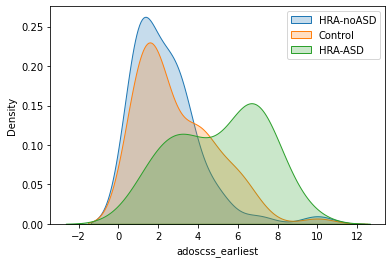

In [14]:
for group in dat.group.unique():
    sns.kdeplot(demo_data[demo_data.group == group]["adoscss_earliest"], fill=True, label=group)
plt.legend();

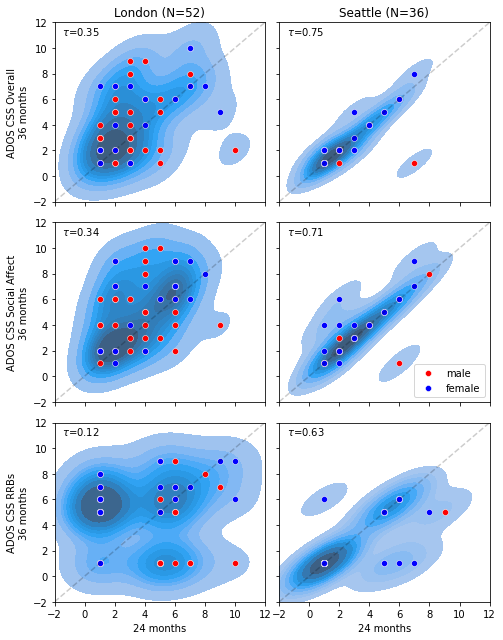

In [15]:
from scipy.stats import kendalltau

fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(7, 9))
for ax_col, site, title in zip(axes.T, ["london", "washington"], ["London", "Seattle"]):
     for ax, dimension, dimension_str in zip(ax_col, ['adoscss', 'ados_sacss', 'ados_rrbcss'], ["Overall", "Social Affect", "RRBs"]):
        x, y = demo_data[demo_data.dataset == site][[f"{dimension}_24m", f"{dimension}_36m"]].dropna(how="any").values.T
        sns.kdeplot(x=x, y=y, fill=True, ax=ax)

        label = dimension == "ados_sacss" and site == "washington"         
        m_x, m_y = demo_data[(demo_data.dataset == site) & (demo_data.sex == "F")][[f"{dimension}_24m", f"{dimension}_36m"]].dropna(how="any").values.T
        f_x, f_y = demo_data[(demo_data.dataset == site) & (demo_data.sex == "M")][[f"{dimension}_24m", f"{dimension}_36m"]].dropna(how="any").values.T
        sns.scatterplot(x=m_x, y=m_y, color="r", ax=ax, label="male" if label else None)
        sns.scatterplot(x=f_x, y=f_y, color="b", ax=ax, label="female" if label else None)
        ax.plot([-2, 12], [-2, 12], linestyle="dashed", color="k", alpha=0.2)
        ax.set_xlim(-2, 12)
        ax.set_ylim(-2, 12)
        ax.set_xlabel(f"24 months")
        ax.set_ylabel(f"ADOS CSS {dimension_str}\n36 months")

        if dimension == "adoscss":
            ax.set_title(title + f" (N={len(m_x) + len(f_x)})")
            
        if label:
            ax.legend(loc="lower right")            
        
        ax.text(-1.5, 11, fr"$\tau$={kendalltau(list(m_x) + list(f_x), list(m_y) + list(f_y))[0]:.2}")

fig.tight_layout()
fig.savefig("images/" + "ados-test-retest.png", dpi=300)

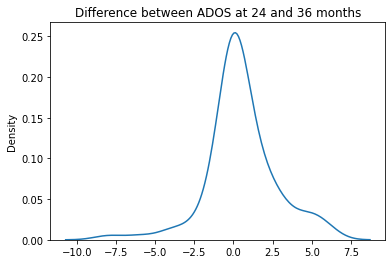

In [16]:
sns.kdeplot(np.diff(demo_data[["adoscss_24m", "adoscss_36m"]].dropna(how="any").values).ravel())
plt.title("Difference between ADOS at 24 and 36 months");

## Outliers labeling
### With LOGIT transform

In [17]:
def label_outliers(dat, func, func_name):
    fig, axes = plt.subplots(2, 3, figsize=(8, 5), sharex=True, sharey=True)
    rejected = []

    tmp = dat.groupby(["subject", "age", "group", "site"]).mean().reset_index()
    min_ = 100
    max_ = -100
    for age, ax in zip([6, 12, 18], axes):
        log_con = func(tmp["con"][tmp.age.values == age])
        min_ = min(min_, np.nanmin(log_con))              
        max_ = max(max_, np.nanmax(log_con))              

    bins = np.linspace(min_-0.01*(max_-min_), 
                       max_+0.01*(max_-min_), 
                       30)
    
    for ((site, age), tmp2), ax in zip(tmp.groupby(["site", "age"]), axes.ravel()):
        log_con = func(tmp2["con"])
        if len(log_con) == 0:
            continue
        Q1, Q2, Q3 = np.nanpercentile(log_con, [25, 50, 75])
        x = ax.hist(log_con[tmp2.group == "Control"], bins=bins, color="green", label="TLA")
        y = ax.hist(log_con[tmp2.group == "HRA-noASD"], bins=bins, bottom=x[0], color="orange", label="ELA-noASD")
        ax.hist(log_con[tmp2.group == "HRA-ASD"], bins=bins, bottom=x[0] + y[0], color="red", label="ELA-ASD")
        ax.axvline(x=Q3 + 1.5*(Q3-Q1), color="r", linestyle="--")
        ax.axvline(x=Q1 - 1.5*(Q3-Q1), color="r", linestyle="--")

        ax.axvline(x=Q1, color="k", linestyle="--")
        ax.axvline(x=Q2, color="k")
        ax.axvline(x=Q3, color="k", linestyle="--")  

        if site == "London":
            ax.set_title("{} months".format(age))

        rejected.append(tmp2[(log_con > Q3 + 1.5*(Q3-Q1)) | (log_con < Q1 - 1.5*(Q3-Q1))])

    axes[0, 0].set_ylabel("Nb. subjects - London")
    axes[1, 0].set_ylabel("Nb. subjects - Seattle")
    
    if func_name == "identity":
        axes[1, 0].set_xlabel("logit(CON)")
        axes[1, 1].set_xlabel("logit(CON)")
    else:
        axes[1, 0].set_xlabel(func_name + "(CON)")
        axes[1, 1].set_xlabel(func_name + "(CON)")        
        
    ax.legend()

    rejected = pd.concat(rejected)
    print(rejected.groupby(["age", "group", "site"]).count()["subject"])

    subject_age = ["{}-{}".format(subject, age) for subject, age in zip(dat.subject, dat.age)]
    rejected_subject_age = ["{}-{}".format(subject, age) for subject, age in zip(rejected.subject, rejected.age)]
    dat["outliers_" + func_name] = np.in1d(subject_age, rejected_subject_age)

    fig.tight_layout(h_pad=2, w_pad=1)
    fig.savefig("images/" + func_name + "_connectivity_outliers.png", dpi=300)

/Users/christian/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/christian/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/christian/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


age  group      site   
6    Control    London     1
                Seattle    0
     HRA-noASD  London     1
                Seattle    1
     HRA-ASD    London     0
                Seattle    1
12   Control    London     2
                Seattle    4
     HRA-noASD  London     1
                Seattle    0
     HRA-ASD    London     0
                Seattle    0
18   Control    London     0
                Seattle    1
     HRA-noASD  London     0
                Seattle    1
     HRA-ASD    London     0
                Seattle    0
Name: subject, dtype: int64


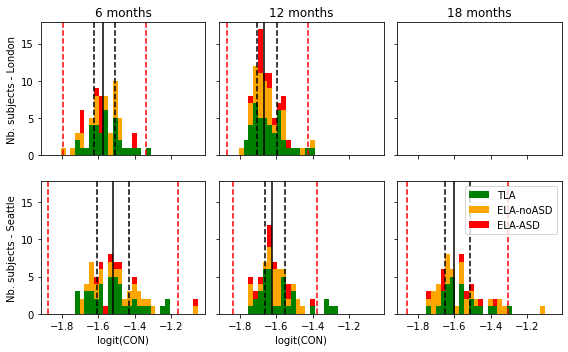

In [18]:
def logit(x):
    return np.log(x/(1-x))

label_outliers(dat, logit, "logit")    

In [19]:
tmp = dat[(~dat.outliers_logit) & (dat.age != 18)]

# Keeping only subject with recordings for at both 6 and 12 months because
# we will average across age and we want to avoid differences in age
# between groups to affect the result
tmp = tmp[get_ind_both_time_point(tmp)]
tmp["log_con"] = logit(tmp.con)

# Average across age
tmp = tmp.groupby(["region1", "region2", "site", "group", "subject", "sex"],
                  observed=True).mean().reset_index()

tmp2 = tmp.copy()
tmp2.region2 = tmp.region1
tmp2.region1 = tmp.region2
tmp3 = pd.concat([tmp, tmp2])

mats = {}
for group in np.unique(tmp3.group):
    tmp4 = tmp3[tmp3.group == group].groupby(["region1", "region2", "site", "age"]).mean()["log_con"]
    tmp4 = tmp4.reset_index().groupby(["region1", "region2"]).mean().reset_index().drop(columns=["age"])
    mats[group] = tmp4.pivot_table(index="region1", columns="region2")
    mats[group][np.eye(len(tmp4.region1.unique())).astype(bool)] = 0

In [20]:
def plot_con_graph(mat, n_lines=300, subjects_dir = ".", **kwargs):
    # Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
    labels = acareeg.infantmodels.get_template_labels(age=12, parc='aparc', subjects_dir=subjects_dir)
    label_colors = [label.color for label in labels]

    # First, we reorder the labels based on their location in the left hemi
    label_names = [label.name for label in labels]
    label_names = [name for name in label_names if name in mat.columns and "parahippocampal" not in name]
    con_mat = mat.loc[label_names, label_names].values

    lh_labels = [name for name in label_names if name.endswith('lh')]

    # Get the y-location of the label
    label_ypos = list()
    for name in lh_labels:
        idx = label_names.index(name)
        ypos = np.mean(labels[idx].pos[:, 1])
        label_ypos.append(ypos)

    # Reorder the labels based on their location
    lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

    # For the right hemi
    rh_labels = [label[:-2] + 'rh' for label in lh_labels if label in label_names]

    # Save the plot order and create a circular layout
    node_order = list()
    node_order.extend(lh_labels[::-1])  # reverse the order
    node_order.extend(rh_labels)

    node_angles = mne.viz.circular_layout(label_names, node_order, start_pos=90,
                                  group_boundaries=[0, len(label_names) / 2])
    
    
    
    #figs, ax = mne.viz.plot_connectivity_circle(tmp, [""]*len(channels), vmin=0, vmax=tmp.max(),
    #                                                        node_angles=angles, n_lines=np.sum(tmp > 0),
    #                                                        colorbar=False, title=f"{band} ({np.round(tmp.max(), 2)})",
    #                                                        show=False)    
    
    
    # Plot the graph using node colors from the FreeSurfer parcellation. We only
    # show the 300 strongest connections.
    return mne_connectivity.viz.plot_connectivity_circle(con_mat, [""]*len(label_names), 
                                            n_lines=n_lines,
                                            node_angles=node_angles, node_colors=label_colors,
                                            **kwargs)[0]

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


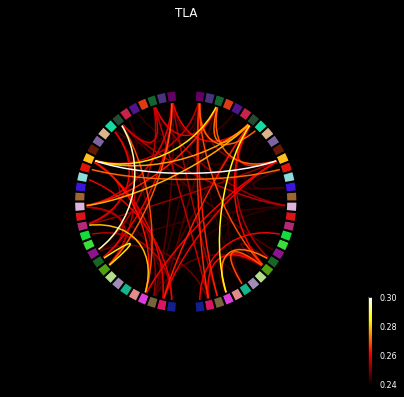

In [21]:
fig_abs = plot_con_graph(np.exp(mats['Control']["log_con"]),  #vmin=0.05, vmax=0.08, 
                     vmin=0.24, vmax=0.3, 
                     title="TLA")
fig_abs.savefig("images/" + "con_plot_control.png", dpi=300)

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


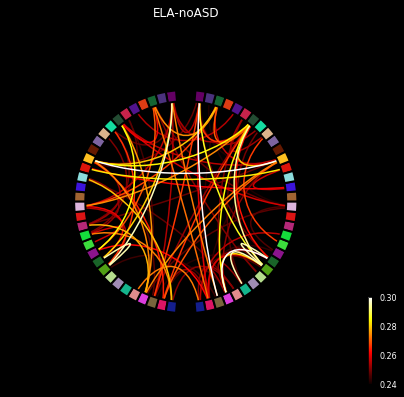

In [22]:
fig = plot_con_graph(np.exp(mats['HRA-noASD']["log_con"]), 
               vmin=0.24, vmax=0.3, 
               n_lines=100, title="ELA-noASD")
fig.savefig("images/" + "con_plot_HRA-noASD.png", dpi=300)



Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


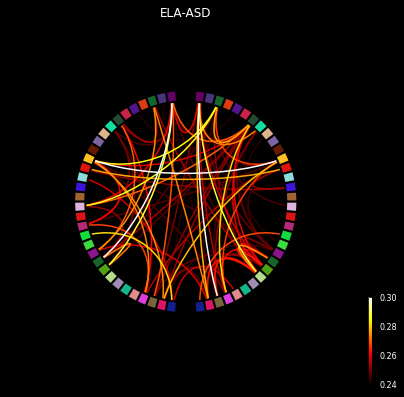

In [23]:
fig = plot_con_graph(np.exp(mats['HRA-ASD']["log_con"]), 
               vmin=0.24, vmax=0.3,
               n_lines=100, title="ELA-ASD")
fig.savefig("images/" + "con_plot_HRA-ASD.png", dpi=300)



Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


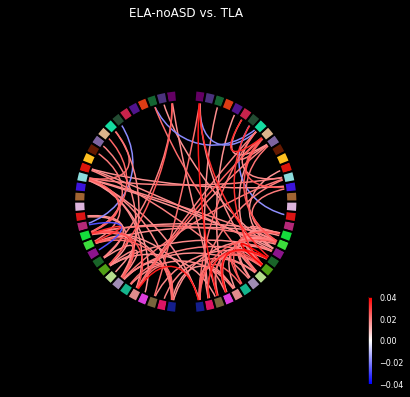

In [24]:
fig_diff = plot_con_graph(np.exp(mats['HRA-noASD']["log_con"]) - np.exp(mats['Control']["log_con"]), 
               vmin=-0.04, vmax=0.04, 
               n_lines=100, colormap="bwr", title="ELA-noASD vs. TLA")
fig_diff.savefig("images/" + "con_plot_HRA-Control.png", dpi=300)



Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


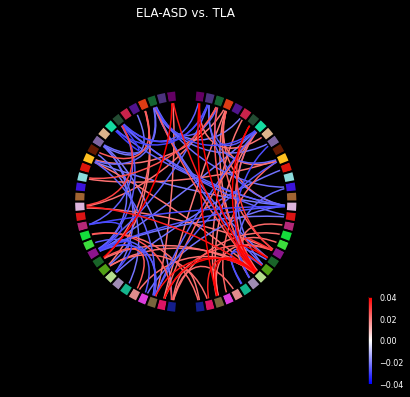

In [25]:
fig = plot_con_graph(np.exp(mats['HRA-ASD']["log_con"]) - np.exp(mats['Control']["log_con"]), 
               vmin=-0.04, vmax=0.04, 
               n_lines=100, colormap="bwr", title="ELA-ASD vs. TLA")
fig.savefig("images/" + "con_plot_ASD-Control.png", dpi=300)



con_plot_control.png
con_plot_HRA-noASD.png
con_plot_HRA-ASD.png

con_plot_HRA-Control.png
con_plot_ASD-Control.png


/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_65002/1476182307.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


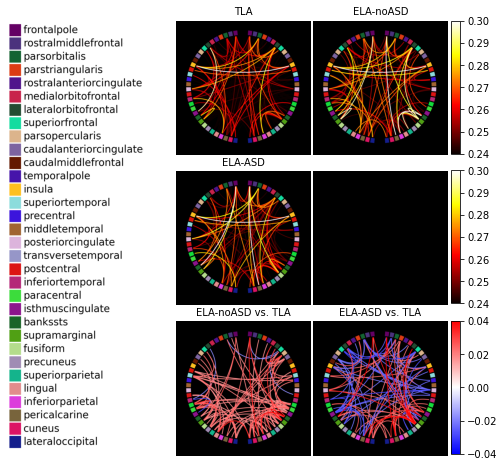

In [26]:
from itertools import product
import matplotlib as mpl


fig = plt.figure(figsize=(8.3, 8))

img_file_names = ["con_plot_control.png", "con_plot_HRA-noASD.png", "con_plot_HRA-ASD.png", "", "con_plot_HRA-Control.png", "con_plot_ASD-Control.png"]
titles = ["TLA", "ELA-noASD", "ELA-ASD", "", "ELA-noASD vs. TLA", "ELA-ASD vs. TLA"]

gs = fig.add_gridspec(3, 3,  width_ratios=(7, 5, 5), wspace=0.01, hspace=0.12) #height_ratios=(2, 7),
                      #left=0.1, right=0.9, bottom=0.1, top=0.9,
                      #wspace=0.05, hspace=0.05)

axes = np.array([fig.add_subplot(gs[i, j+1]) for i, j in product(range(3), range(2))]).ravel()

for ax, file_name, title in zip(axes, img_file_names, titles):
    print(file_name)
    if file_name == "":
        img[..., :3] = 0
    else:
        img = plt.imread("images/" + file_name)[650:-650, 500:-800]
    ax.imshow(img)
    ax.axis(False)
    ax.set_title(title, size=10)

    
#ax =  fig.add_subplot(gs[0, -1])
ax = fig.add_axes([0.905, 0.649, 0.015, 0.231])
cmap = mpl.cm.hot
norm = mpl.colors.Normalize(vmin=0.24, vmax=0.3)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, extendfrac=0.04)    
    
ax = fig.add_axes([0.905, 0.389, 0.015, 0.231])    
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, extendfrac=0.04)   
    
ax = fig.add_axes([0.905, 0.128, 0.015, 0.231])
cmap = mpl.cm.bwr
norm = mpl.colors.Normalize(vmin=-0.04, vmax=0.04)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, extendfrac=0.04)    
        
    
#ax.legend(bbox_to_anchor=(1.1, 1.05))    
    
ax_legend = fig.add_subplot(gs[:, 0]) 
img = plt.imread("legend.png")
ax_legend.imshow(img)
ax_legend.axis(False)

fig.savefig("images/" + "con_plot_all.png", dpi=300)
fig.tight_layout()

/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_65002/1087338194.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["log_con"] = logit(tmp.con)


Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


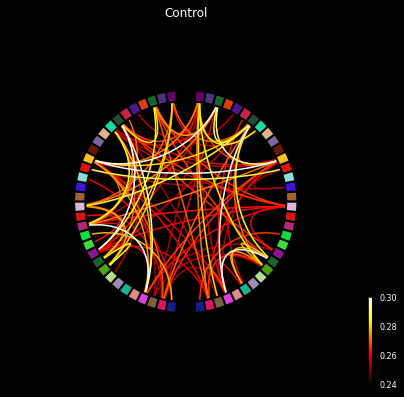

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


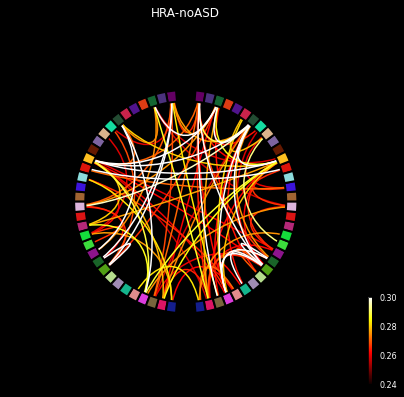

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


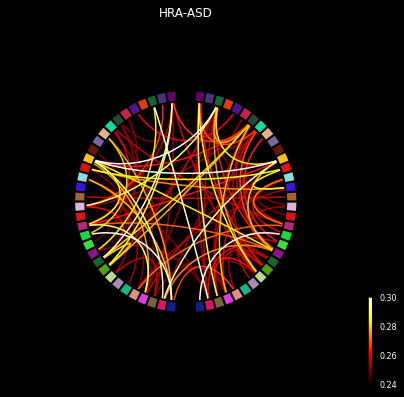

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


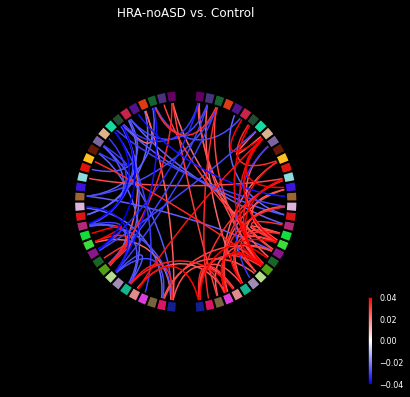

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


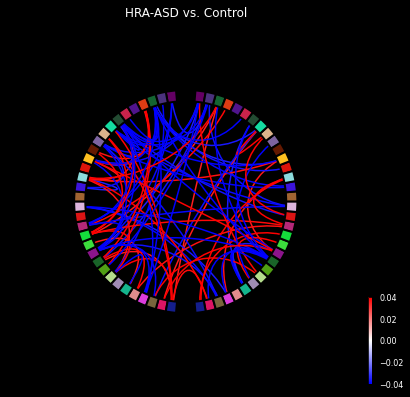

con_plot_control_6.png
con_plot_HRA-noASD_6.png
con_plot_HRA-ASD_6.png

con_plot_HRA-Control_6.png
con_plot_ASD-Control_6.png


/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_65002/1087338194.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_65002/1087338194.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["log_con"] = logit(tmp.con)


Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


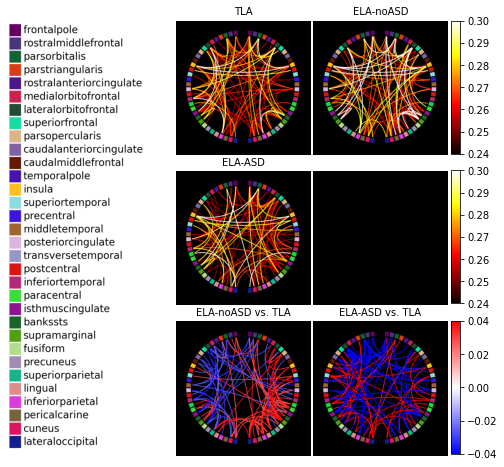

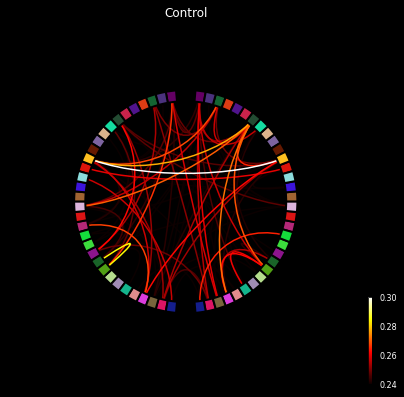

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


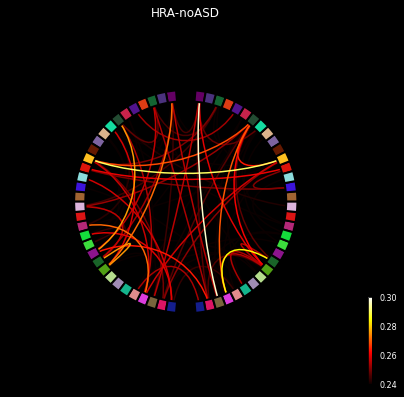

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


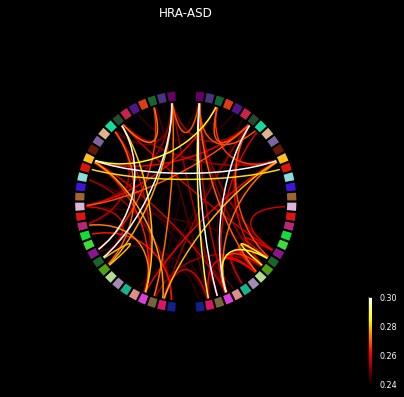

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


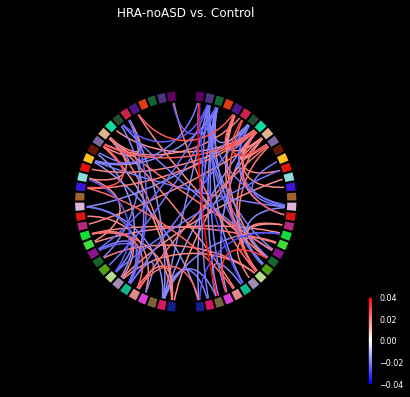

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


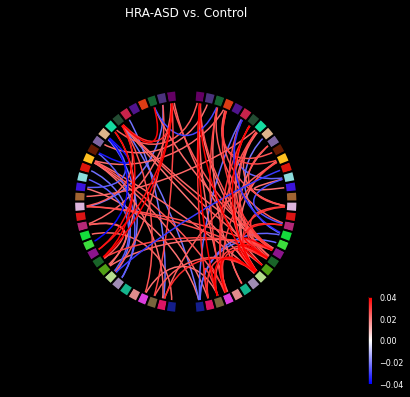

con_plot_control_12.png
con_plot_HRA-noASD_12.png
con_plot_HRA-ASD_12.png

con_plot_HRA-Control_12.png
con_plot_ASD-Control_12.png


/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_65002/1087338194.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_65002/1087338194.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["log_con"] = logit(tmp.con)


Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


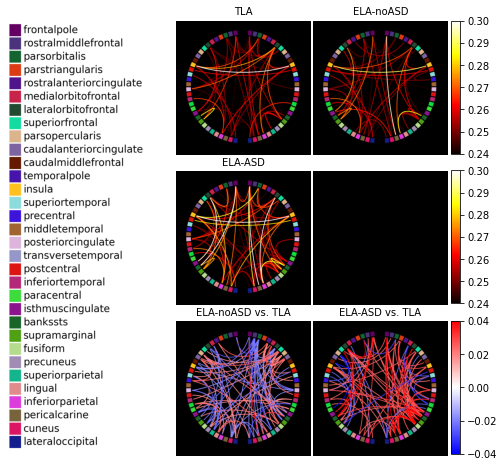

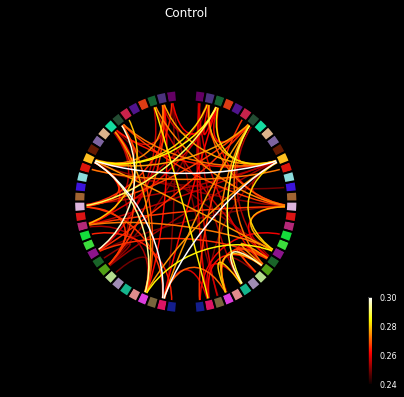

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


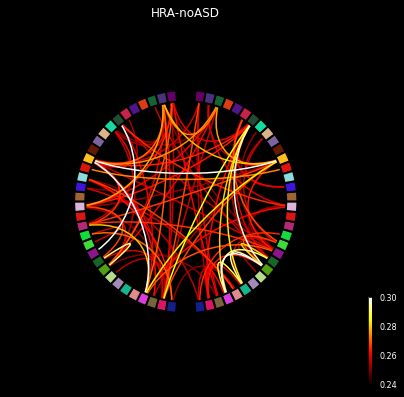

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


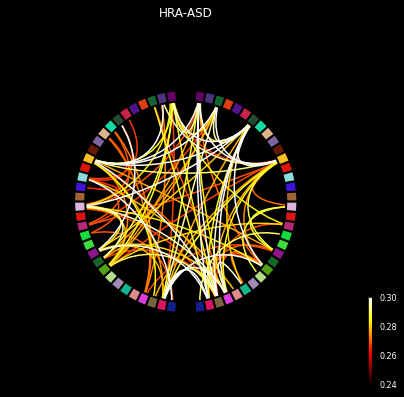

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


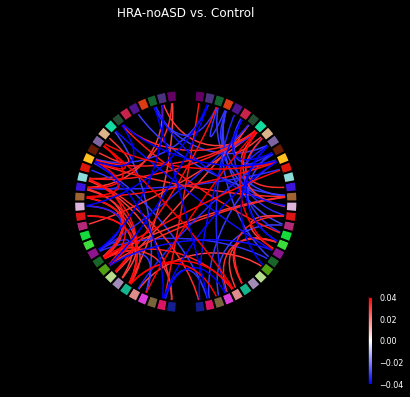

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


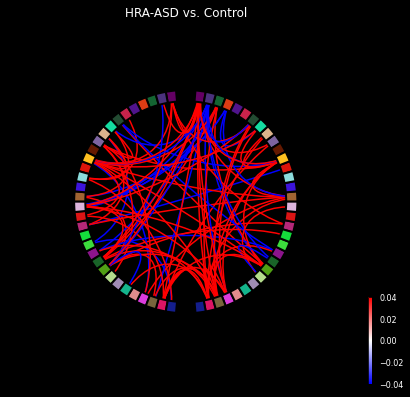

con_plot_control_18.png
con_plot_HRA-noASD_18.png
con_plot_HRA-ASD_18.png

con_plot_HRA-Control_18.png
con_plot_ASD-Control_18.png


/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_65002/1087338194.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


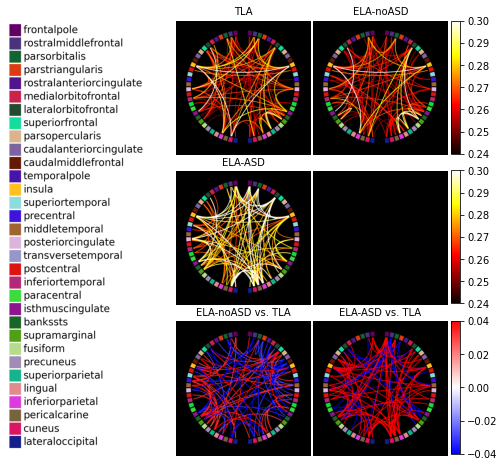

In [27]:
for age in [6, 12, 18]:
    
    tmp = dat[(~dat.outliers_logit) & (dat.age == age)]
    tmp["log_con"] = logit(tmp.con)

    tmp2 = tmp.copy()
    tmp2.region2 = tmp.region1
    tmp2.region1 = tmp.region2
    tmp3 = pd.concat([tmp, tmp2])

    mats = {}
    for group in np.unique(tmp3.group):
        tmp4 = tmp3[tmp3.group == group].groupby(["region1", "region2", "site", "age"]).mean()["log_con"]
        tmp4 = tmp4.reset_index().groupby(["region1", "region2"]).mean().reset_index().drop(columns=["age"])
        mats[group] = tmp4.pivot_table(index="region1", columns="region2")
        mats[group][np.eye(len(tmp4.region1.unique())).astype(bool)] = 0    


    for group in ['Control', 'HRA-noASD', 'HRA-ASD']:
        plot_con_graph(np.exp(mats[group]["log_con"]), vmin=0.24, vmax=0.3,
                       n_lines=100, title=group).savefig("images/" + f"con_plot_{group}_{age}.png", dpi=300)

    plot_con_graph(np.exp(mats['HRA-noASD']["log_con"]) - np.exp(mats['Control']["log_con"]), vmin=-0.04, vmax=0.04, 
               n_lines=100, colormap="bwr", title="HRA-noASD vs. Control").savefig("images/" + f"con_plot_HRA-Control_{age}.png", dpi=300)

    plot_con_graph(np.exp(mats['HRA-ASD']["log_con"]) - np.exp(mats['Control']["log_con"]), vmin=-0.04, vmax=0.04, 
               n_lines=100, colormap="bwr", title="HRA-ASD vs. Control").savefig("images/" + f"con_plot_ASD-Control_{age}.png", dpi=300)
    
    
    fig = plt.figure(figsize=(8.3, 8))

    img_file_names = [f"con_plot_control_{age}.png", f"con_plot_HRA-noASD_{age}.png", f"con_plot_HRA-ASD_{age}.png", 
                      "", f"con_plot_HRA-Control_{age}.png", f"con_plot_ASD-Control_{age}.png"]
    titles = ["TLA", "ELA-noASD", "ELA-ASD", "", "ELA-noASD vs. TLA", "ELA-ASD vs. TLA"]

    gs = fig.add_gridspec(3, 3,  width_ratios=(7, 5, 5), wspace=0.01, hspace=0.12) #height_ratios=(2, 7),
                          #left=0.1, right=0.9, bottom=0.1, top=0.9,
                          #wspace=0.05, hspace=0.05)

    axes = np.array([fig.add_subplot(gs[i, j+1]) for i, j in product(range(3), range(2))]).ravel()

    for ax, file_name, title in zip(axes, img_file_names, titles):
        print(file_name)
        if file_name == "":
            img[..., :3] = 0
        else:
            img = plt.imread("images/" + file_name)[650:-650, 500:-800]
        ax.imshow(img)
        ax.axis(False)
        ax.set_title(title, size=10)


    #ax =  fig.add_subplot(gs[0, -1])
    ax = fig.add_axes([0.905, 0.649, 0.015, 0.231])
    cmap = mpl.cm.hot
    norm = mpl.colors.Normalize(vmin=0.24, vmax=0.3)
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, extendfrac=0.04)    

    ax = fig.add_axes([0.905, 0.389, 0.015, 0.231])    
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, extendfrac=0.04)   

    ax = fig.add_axes([0.905, 0.128, 0.015, 0.231])
    cmap = mpl.cm.bwr
    norm = mpl.colors.Normalize(vmin=-0.04, vmax=0.04)
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, extendfrac=0.04)    


    #ax.legend(bbox_to_anchor=(1.1, 1.05))    

    ax_legend = fig.add_subplot(gs[:, 0]) 
    img = plt.imread("legend.png")
    ax_legend.imshow(img)
    ax_legend.axis(False)

    fig.savefig("images/" + f"con_plot_all_{age}.png", dpi=300)
    fig.tight_layout()    

    

In [28]:
formula = "log_con ~ group + sex + site*age"
counts = None
positive = None
counts_under_asd = 0
counts_under_noasd = 0
for (g1, g2), df in tqdm(list(tmp.groupby(["region1", "region2"]))):
    lm = smf.ols(formula, df).fit()
    if counts is None:
        counts = (lm.pvalues < 0.05).astype(int)   
    else:
        counts += (lm.pvalues < 0.05).astype(int)
        
    if lm.pvalues[1] < 0.05:
        counts_under_noasd += np.sign(lm.params[1])
    if lm.pvalues[2] < 0.05:
        counts_under_asd += np.sign(lm.params[2])
        
counts, counts_under_noasd, counts_under_asd

  0%|          | 0/2080 [00:00<?, ?it/s]

(Intercept             2080
 group[T.HRA-noASD]      90
 group[T.HRA-ASD]        86
 sex[T.M]                96
 age                   2080
 dtype: int64,
 -16.0,
 44.0)

In [29]:
tmp.subject.unique().shape

(57,)

In [30]:
ados_strs = ['adoscss_earliest', 'ados_sacss_earliest', 'ados_rrbcss_earliest']

for ados_str in ados_strs:
    formula = f"log_con ~ {ados_str}*sex + site*age"
    counts = None
    positive = None
    counts_under_asd = 0
    for (g1, g2), df in tqdm(list(tmp.groupby(["region1", "region2"]))):
        #print(df.shape, g1, g2)
        lm = smf.ols(formula, df).fit()
        if counts is None:
            counts = (lm.pvalues < 0.05).astype(int)   
        else:
            counts += (lm.pvalues < 0.05).astype(int)

        if lm.pvalues[ados_str] < 0.05:
            counts_under_asd += np.sign(lm.params[ados_str])

    print("")
    print(ados_str)
    print(counts, counts_under_asd)

  0%|          | 0/2080 [00:00<?, ?it/s]


adoscss_earliest
Intercept                    2080
sex[T.M]                      106
adoscss_earliest               89
adoscss_earliest:sex[T.M]     119
age                          2080
dtype: int64 21.0


  0%|          | 0/2080 [00:00<?, ?it/s]


ados_sacss_earliest
Intercept                       2080
sex[T.M]                          65
ados_sacss_earliest              129
ados_sacss_earliest:sex[T.M]      67
age                             2080
dtype: int64 19.0


  0%|          | 0/2080 [00:00<?, ?it/s]


ados_rrbcss_earliest
Intercept                        2080
sex[T.M]                          155
ados_rrbcss_earliest               79
ados_rrbcss_earliest:sex[T.M]     123
age                              2080
dtype: int64 25.0


### Sample size after outlier rejection

In [31]:
print_N(dat[~dat.outliers_logit])

age                   6      12     18
site    group                         
London  Control    11/21  20/21    0/0
        HRA-noASD   6/16   9/22    0/0
        HRA-ASD      9/2   10/5    0/0
Seattle Control    24/15  16/14  12/12
        HRA-noASD   20/6   19/5   18/6
        HRA-ASD      2/5    4/6    4/5

age           6      12     18
group                         
Control    35/36  36/35  12/12
HRA-noASD  26/22  28/27   18/6
HRA-ASD     11/7  14/11    4/5

# Distribution raw data only

In [32]:
# resting state networks: default mode network (DMN), dorsal attentional network (DAN), salience network (SAN), auditory network (AUD), visual network (VIS)
# As per: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5462789/
dmn_aparc_mapping = {'Default mode': ['isthmuscingulate', 'medialorbitofrontal', 'posteriorcingulate', 
                             'precuneus', 'rostralanteriorcingulate', 'lateralorbitofrontal', 
                             'parahippocampal'],
                     'Dorsal attentional': ['caudalanteriorcingulate', 'inferiortemporal', 'middletemporal',
                             'parsopercularis', 'parsorbitalis', 'parstriangularis'],
                     'Salience': ['insula', 'rostralmiddlefrontal', 'supramarginal', 'caudalmiddlefrontal'],
                     'Auditory': ['superiortemporal'],
                     'Visual': ['cuneus', 'lateraloccipital', 'fusiform', 'lingual']}


In [33]:
region_to_network = dict(zip(np.concatenate(list(dmn_aparc_mapping.values())), 
                             np.concatenate([[network]*len(regions) for network, regions in dmn_aparc_mapping.items()])))

In [34]:
dat["network1"] = dat.region1.str.replace("-rh", "").str.replace("-lh", "").map(region_to_network)
dat["network2"] = dat.region2.str.replace("-rh", "").str.replace("-lh", "").map(region_to_network)
dat["network"] = [n1 if n1 == n2 else np.nan for n1, n2 in zip(dat.network1, dat.network2)]

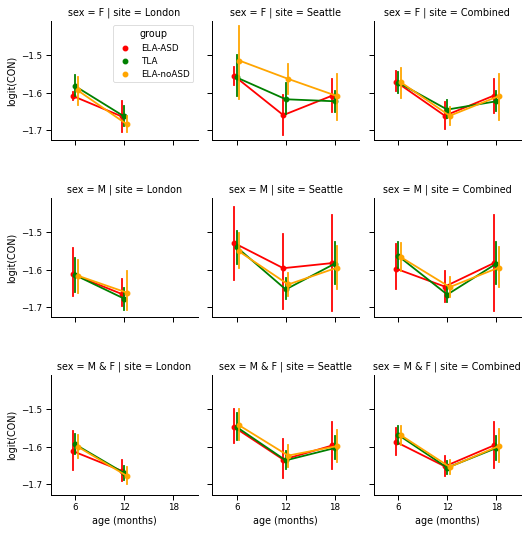

In [35]:
tmp = dat.copy()
tmp["log_con"] = logit(tmp.con)
tmp = tmp[~tmp.outliers_logit]

tmp2 = tmp.copy()
tmp2["site"] = "Combined"
tmp = pd.concat([tmp, tmp2])
tmp2 = tmp.copy()
tmp2["sex"] = "M & F"
tmp = pd.concat([tmp, tmp2])

paper_rc = {'lines.linewidth': 0.5}                  
sns.set_context("paper", rc = paper_rc)  

palette = sns.color_palette(["red", "green", "orange"])

plot_kwds = {"x":"age", "hue":"group",
             "dodge":0.1, "palette":palette, 
             "hue_order":["ELA-ASD", "TLA", "ELA-noASD"],
             "join": True} #, "facet_kws":{"alpha": 0.5}


paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)  

tmp3 = tmp.groupby(["age", "subject", "sex", "site", "group"], observed=True).mean()[["log_con"]].reset_index()

tmp3.group = tmp3.group.astype(str)
tmp3.loc[tmp3.group == "Control", "group"] = "TLA"
tmp3.loc[tmp3.group == "HRA-ASD", "group"] = "ELA-ASD"
tmp3.loc[tmp3.group == "HRA-noASD", "group"] = "ELA-noASD"


g = sns.catplot(data=tmp3, row="sex", col="site", kind="point", y="log_con", 
                col_order=["London", "Seattle", "Combined"], 
                row_order=["F", "M", "M & F"], legend_out=False, 
                height=2.5, aspect=1, **plot_kwds)

for ax in g.axes.T[0]:
    ax.set_ylabel("logit(CON)")
    
for ax in g.axes[-1]:
    ax.set_xlabel("age (months)")
for ax in g.axes[0]:
    ax.set_xlabel("")

g.fig.tight_layout(h_pad=4, w_pad=1)
g.fig.savefig("images/" + "all_relationships.png", dpi=300)

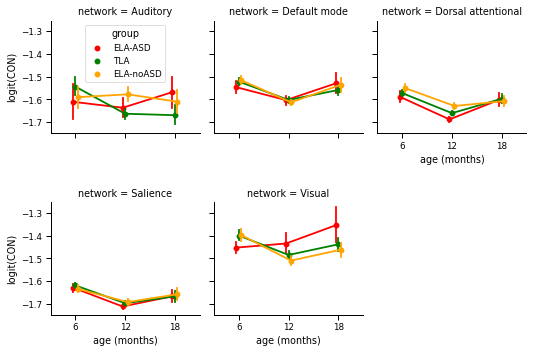

In [36]:
palette = sns.color_palette(["red", "green", "orange"])


tmp3 = tmp.groupby(["age", "subject", "sex", "site", "group", "network"], observed=True).mean()[["log_con"]].reset_index()

tmp3.group = tmp3.group.astype(str)
tmp3.loc[tmp3.group == "Control", "group"] = "TLA"
tmp3.loc[tmp3.group == "HRA-ASD", "group"] = "ELA-ASD"
tmp3.loc[tmp3.group == "HRA-noASD", "group"] = "ELA-noASD"


g = sns.catplot(data=tmp3,  col="network", kind="point", y="log_con",  col_wrap=3, legend_out=False, 
                height=2.5, aspect=1, **plot_kwds)

for ax in g.axes[[0, 3]]:
    ax.set_ylabel("logit(CON)")
    
for ax in g.axes[2:]:
    ax.set_xlabel("age (months)")
#for ax in g.axes[0]:
#    ax.set_xlabel("")

g.fig.tight_layout(h_pad=4, w_pad=1)
g.fig.savefig("images/" + "network_relationships.png", dpi=300)

### Regional specificity
- logit-transformed
- Outlier rejected

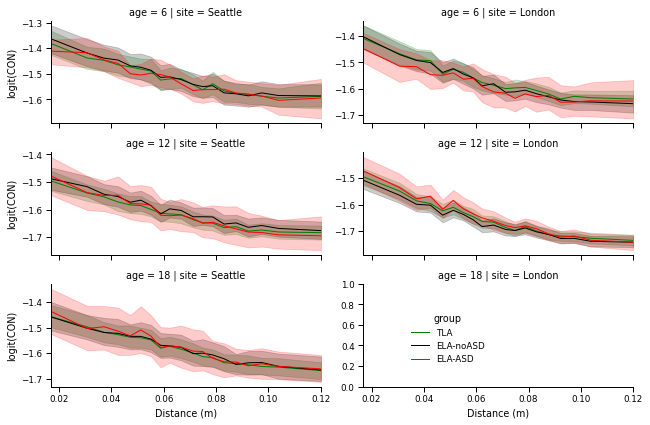

In [37]:
del dat["dist_bin"]
add_bin_dist(dat, "dist", 20)

tmp = dat[~dat.outliers_logit].groupby(["dist_bin", "subject", "site", "age", "group"], observed=True).mean().reset_index()
tmp["log_con"] = logit(tmp.con)

tmp.group = tmp.group.astype(str)
tmp.loc[tmp.group == "Control", "group"] = "TLA"
tmp.loc[tmp.group == "HRA-ASD", "group"] = "ELA-ASD"
tmp.loc[tmp.group == "HRA-noASD", "group"] = "ELA-noASD"

g = sns.relplot(x="dist_bin", y="log_con", kind="line", hue="group", col="site", row="age",
                data=tmp, facet_kws={"sharex":True, "sharey":False},
                palette=sns.color_palette(["green", "black", "red"]), 
                hue_order=["TLA", "ELA-noASD", "ELA-ASD"], height=2, aspect=2)
for ax in g.axes.ravel():
    ax.set_xlim(np.min(tmp.dist_bin), np.max(tmp.dist_bin))

for ax in g.axes[-1]:
    ax.set_xlabel("Distance (m)")
for ax_row in g.axes:
    ax_row[0].set_ylabel("logit(CON)")

leg = g._legend
leg.set_bbox_to_anchor([0.75, 0.2])    

plt.tight_layout()
plt.savefig("images/" + "line_plot_distance_effect_logit_outliers_rejected.png", dpi=300)

### Confirmatory model (i.e., smaller simpler model, with less statistical power but less possible pitfalls)

In [38]:
tmp = dat[~dat.outliers_logit].groupby(["site", "age", "group", "subject", "sex"], observed=True).mean().reset_index()
tmp["log_con"] = logit(tmp.con)
tmp = tmp.groupby(["site", "group", "subject", "sex"],
                  observed=True).mean().reset_index()


formula = "log_con ~ group*sex + site*age"
md = smf.ols(formula, tmp)
#table = sm.stats.anova_lm(md.fit(), typ=3)
#table
md.fit().pvalues, md.fit().params


(Intercept                      2.600665e-84
 group[T.HRA-noASD]             5.081019e-01
 group[T.HRA-ASD]               3.362442e-01
 sex[T.M]                       8.304390e-01
 site[T.Seattle]                2.540907e-01
 group[T.HRA-noASD]:sex[T.M]    8.700127e-01
 group[T.HRA-ASD]:sex[T.M]      3.591108e-01
 age                            4.903796e-05
 site[T.Seattle]:age            1.095657e-02
 dtype: float64,
 Intercept                     -1.455969
 group[T.HRA-noASD]            -0.011562
 group[T.HRA-ASD]              -0.023203
 sex[T.M]                      -0.003437
 site[T.Seattle]               -0.065160
 group[T.HRA-noASD]:sex[T.M]    0.004054
 group[T.HRA-ASD]:sex[T.M]      0.030279
 age                           -0.016527
 site[T.Seattle]:age            0.013682
 dtype: float64)

In [39]:
tmp = dat[~dat.outliers_logit].groupby(["site", "age", "group", "subject", "sex"], observed=True).mean().reset_index()
tmp["log_con"] = logit(tmp.con)

# 3.a
formula = "log_con ~ group*sex + site*age"
md = smf.mixedlm(formula, tmp, groups="subject_no")
print(md.fit().pvalues, md.fit().params)
print(tmp.shape[0], tmp.groupby("subject_no").mean().shape[0])

/Users/christian/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Intercept                      0.000000e+00
group[T.HRA-noASD]             7.606273e-01
group[T.HRA-ASD]               4.565455e-01
sex[T.M]                       7.156714e-01
site[T.Seattle]                7.072138e-01
group[T.HRA-noASD]:sex[T.M]    7.776640e-01
group[T.HRA-ASD]:sex[T.M]      3.913988e-01
age                            8.198299e-08
site[T.Seattle]:age            4.891000e-03
subject_no Var                 1.000000e+00
dtype: float64 Intercept                     -1.484937e+00
group[T.HRA-noASD]             5.163978e-03
group[T.HRA-ASD]              -1.694703e-02
sex[T.M]                      -5.473571e-03
site[T.Seattle]               -1.201167e-02
group[T.HRA-noASD]:sex[T.M]   -6.547052e-03
group[T.HRA-ASD]:sex[T.M]      2.676029e-02
age                           -1.411143e-02
site[T.Seattle]:age            8.436115e-03
subject_no Var                 8.373420e-10
dtype: float64
345 179


/Users/christian/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [40]:
# 3.b

tmp2 = tmp[(~np.isnan(tmp.adoscss_latest)) & (tmp.group != "Control")]
formula = "log_con ~ adoscss_earliest*sex + site*age"
md = smf.mixedlm(formula, tmp2, groups="subject_no")
print(md.fit().pvalues, md.fit().params)
print(tmp2.shape[0], tmp2.groupby("subject_no").mean().shape[0])
print(md.fit().pvalues["age"])

/Users/christian/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/christian/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/christian/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/christian/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Intercept                    7.215856e-304
sex[T.M]                      8.979597e-02
site[T.Seattle]               5.702131e-01
adoscss_earliest              1.805160e-01
adoscss_earliest:sex[T.M]     1.242101e-01
age                           4.420871e-05
site[T.Seattle]:age           2.502724e-01
subject_no Var                1.000000e+00
dtype: float64 Intercept                   -1.467162e+00
sex[T.M]                    -4.832274e-02
site[T.Seattle]              2.718146e-02
adoscss_earliest            -6.800017e-03
adoscss_earliest:sex[T.M]    1.060185e-02
age                         -1.352704e-02
site[T.Seattle]:age          4.808465e-03
subject_no Var               7.577284e-09
dtype: float64
130 71
4.420870607288588e-05


/Users/christian/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/christian/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


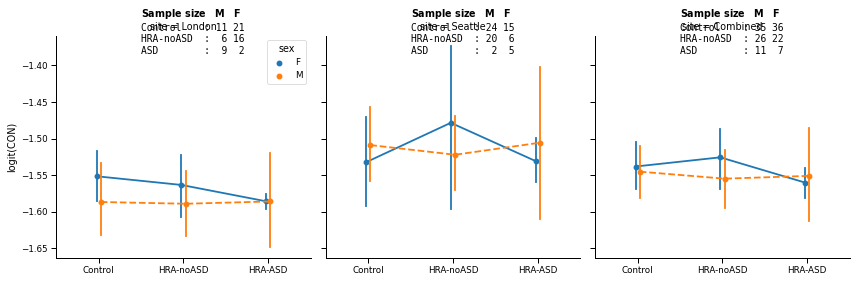

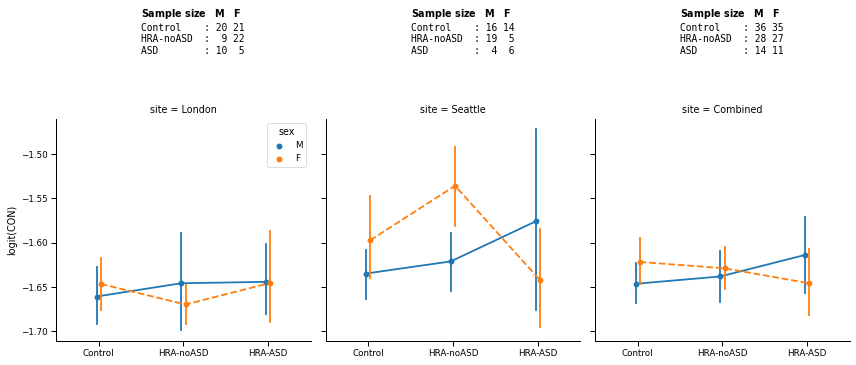

In [41]:
for age in [6, 12]:
    tmp = dat[~dat.outliers_logit].groupby(["site", "age", "group", "subject", "sex"], observed=True).mean().reset_index()
    tmp = tmp[np.in1d(tmp.group, ["Control", "HRA-ASD", "HRA-noASD"])]
    tmp.group = tmp.group.astype(str) 
    tmp["log_con"] = logit(tmp.con)
    tmp = tmp[tmp.age == age]
    tmp = tmp.groupby(["site", "group", "subject", "sex"], observed=True).mean().reset_index()

    site_means = tmp.groupby(["site", "sex", "group"], observed=True).mean()
    site_means = site_means.groupby(["site", "sex"], observed=True).mean()
    site_means = site_means.groupby(["site"], observed=True).mean()

    tmp2 = tmp.copy()
    for site in ["London", "Seattle"]:
        inds = (tmp.site == site)
        tmp2.loc[inds, "log_con"] -= site_means.loc[site]["log_con"]
        tmp2.loc[inds, "log_con"] += site_means["log_con"].values.mean()
    tmp2.site = "Combined"
    tmp3 = pd.concat([tmp, tmp2])

    col_order=["London", "Seattle", "Combined"]

    g = sns.catplot(kind="point", col="site", x="group", hue="sex", linestyles=["solid", "dashed"],
                    y="log_con", col_order=col_order, height=4, order=["Control", "HRA-noASD", "HRA-ASD"],
                    data=tmp3, dodge=0.05, legend_out=False)

    group_N = tmp3.groupby(["site", "group", "sex", "subject"], observed=True).mean().reset_index()\
                  .groupby(["site", "group", "sex"], observed=True).count()[["subject"]]

    from matplotlib import rc
    for ax, site in zip(g.axes.ravel(), col_order):

        string_N = "Control    : {: >2} {: >2}\nHRA-noASD  : {: >2} {: >2}\nASD        : {: >2} {: >2}\n".format(
                        group_N.loc[(site, "Control", "M"), "subject"], group_N.loc[(site, "Control", "F"), "subject"], 
                        group_N.loc[(site, "HRA-noASD", "M"), "subject"], group_N.loc[(site, "HRA-noASD", "F"), "subject"], 
                        group_N.loc[(site, "HRA-ASD", "M"), "subject"], group_N.loc[(site, "HRA-ASD", "F"), "subject"])
        ax.text(x=0.50, y=-1.4, s="$\\bf{Sample\ size\ \ \ M\ \ \ F} $\n" + string_N,
               fontdict= {'family': 'monospace'})

    g.fig.savefig("confirmatory_model_gender_effect.png", dpi=300)   

    g.axes[0, 0].set_ylabel("logit(CON)")
    for ax in g.axes[0]:
        ax.set_xlabel("")

### Regression with ADOS scores

In [42]:
# 'adoscss_24m', 'ados_sacss_24m', 'ados_rrbcss_24m'
def plot_ados_reg(suffix="_earliest"):

    ados_str_map = {f'adoscss{suffix}': "Overall", 
                    f'ados_sacss{suffix}': "Social affect", 
                    f'ados_rrbcss{suffix}': "RRBs"}    
    
    for ados_str in ados_str_map:
        print("")
        print(f"======================== {ados_str} =========================")

        tmp = dat[~dat.outliers_logit].groupby(["site", "age", "group", "subject", "sex"], observed=True).mean().reset_index()
        tmp["log_con"] = logit(tmp.con)
        #tmp = tmp.groupby(["site", "age", "group", "subject", "sex"], observed=True).mean()[["log_con", ados_str]].reset_index()

        formula = f"log_con ~ {ados_str}*sex + site*age"
        md = smf.ols(formula, tmp[tmp.group != "Control"])
        #table = sm.stats.anova_lm(md.fit(), typ=3)
        #table
        print(md.fit().pvalues, md.fit().params)


        sex_site_means = tmp.groupby(["site", "sex"], observed=True).mean()
        sex_means = sex_site_means.groupby("sex").mean()
        mean_log_con = tmp[tmp.group == "Control"].groupby(["site", "sex"], observed=True).mean()["log_con"]

        tmp2 = tmp.copy()
        for site in ["London", "Seattle"]:
            for sex in ["F", "M"]:
                inds = (tmp.sex == sex) & (tmp.site == site) & (tmp.group != "Control")
                tmp2.loc[inds, "log_con"] -= sex_site_means.loc[(site, sex)]["log_con"]
                tmp2.loc[inds, "log_con"] += sex_means.loc[sex]["log_con"]    

        plt.rcParams['figure.facecolor'] = 'white'

        tmp = dat[~dat.outliers_logit]
        tmp["log_con"] = logit(tmp.con)
        tmp = tmp.groupby(["site", "age", "group", "risk", "subject_no", "sex"], observed=True).mean()[["log_con", ados_str]].reset_index()
        mean_log_con = tmp[tmp.group == "Control"].groupby(["site", 'age', "sex"], observed=True).mean()["log_con"]


        dep_var = ados_str
        fig, axes = plt.subplots(2, 3, figsize=(8, 5), sharex=True, sharey=True)
        for ax_row, sex in zip(axes, ["F", "M"]):
            for age, ax in zip([6, 12, 18], ax_row):
                for site, color, x in zip(["London", "Seattle"], ["b", "r"], [1, 6]):       
                    if site == "London" and age == 18:
                        continue
                    inds = (tmp.age == age) & (tmp.sex == sex) & (tmp.site == site) & ~np.isnan(tmp[dep_var])  & (tmp.risk == "HRA")
                    ax.set_xlim(0.5, 10.5)

                    print(site, age, sex, np.sum(inds))

                    sns.regplot(data=tmp[inds], x=dep_var, y="log_con", ax=ax, 
                                color=color, truncate=False, scatter=False, label=site)
                    ax.scatter(tmp[inds & (tmp.group == "HRA-ASD")][ados_str], 
                                tmp[inds & (tmp.group == "HRA-ASD")].log_con, s=30, 
                               color=color, marker="*")                        
                    ax.scatter(tmp[inds & (tmp.group == "HRA-noASD")][ados_str], 
                                tmp[inds & (tmp.group == "HRA-noASD")].log_con, s=15, 
                               color=color, marker=".")            
                    ax.scatter(tmp[inds & (tmp.group == "Control")][ados_str], 
                                tmp[inds & (tmp.group == "Control")].log_con, s=15, 
                               color=color, marker="s")           



                    ax.axhline(y=mean_log_con.loc[site, age, sex], color=color, linestyle="dashed")    

                    rho, p = pearsonr(tmp[dep_var][inds], tmp["log_con"][inds])
                    huber_t = smf.rlm("log_con ~ " + dep_var, data=tmp[inds], M=sm.robust.norms.HuberT())
                    hub_results = huber_t.fit()
                    p = hub_results.pvalues[1]
                    ax.text(x, -1.34, "rho={:.4f}\np={:.4f}".format(rho, p), color=color)


                if age == 18:
                    continue
                inds = (tmp.age == age) & (tmp.sex == sex) & (tmp.group != "Control") & ~np.isnan(tmp[dep_var])   
                rho, p = pearsonr(tmp[dep_var][inds], tmp["log_con"][inds])
                huber_t = smf.rlm("log_con ~ " + dep_var, data=tmp[inds], M=sm.robust.norms.HuberT())
                hub_results = huber_t.fit()
                p = hub_results.pvalues[1]        
                ax.text(x, -1.9, "rho={:.4f}\np={:.4f}".format(rho, p), color="k")
                #abline(hub_results.params[1], hub_results.params[0], ax, color="k", label="pooled")
                sns.regplot(data=tmp[inds], x=dep_var, y="log_con", ax=ax, 
                                color="k", truncate=False, scatter=False, label="Pooled")        


        axes[0, 0].set_ylabel("logit(CIPLV) - Female")        
        axes[1, 0].set_ylabel("logit(CIPLV) - Male")        
        for ax in axes[0, :]:
            ax.set_xlabel("")
        for ax in axes[:, 1:].ravel():
            ax.set_ylabel("")        


        axes[0, 0].set_title("6 months")       
        axes[0, 1].set_title("12 months")       
        axes[0, 2].set_title("18 months")          

        axes[1, 1].set_xlabel(f"ADOS severity scores ({ados_str_map[ados_str]})")       
        axes[1, 0].set_xlabel(f"")       
        axes[1, 2].set_xlabel(f"")       

        axes[1, 0].legend(loc="lower left")

        axes[0, 0].set_ylim(-1.92, -1.21)
        plt.subplots_adjust(wspace=0.001, hspace=0.001, left=0.09,
                            bottom=0.10, right=0.99, top=0.95)
        fig.savefig("images/" + f"sex_{ados_str}_regressions.png", dpi=300)    



======================== adoscss_earliest =========================
Intercept                    6.654109e-70
sex[T.M]                     8.572911e-02
site[T.Seattle]              5.654707e-01
adoscss_earliest             1.751988e-01
adoscss_earliest:sex[T.M]    1.237591e-01
age                          7.392348e-05
site[T.Seattle]:age          2.459755e-01
dtype: float64 Intercept                   -1.467162
sex[T.M]                    -0.048323
site[T.Seattle]              0.027181
adoscss_earliest            -0.006800
adoscss_earliest:sex[T.M]    0.010602
age                         -0.013527
site[T.Seattle]:age          0.004808
dtype: float64


/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_65002/2759810661.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["log_con"] = logit(tmp.con)


London 6 F 18
Seattle 6 F 6
London 12 F 27
Seattle 12 F 6
Seattle 18 F 7
London 6 M 15
Seattle 6 M 10
London 12 M 19
Seattle 12 M 11
Seattle 18 M 11

======================== ados_sacss_earliest =========================
Intercept                       1.928539e-67
sex[T.M]                        7.912657e-02
site[T.Seattle]                 6.054443e-01
ados_sacss_earliest             1.661037e-01
ados_sacss_earliest:sex[T.M]    1.162644e-01
age                             6.328799e-05
site[T.Seattle]:age             2.334140e-01
dtype: float64 Intercept                      -1.460887
sex[T.M]                       -0.054792
site[T.Seattle]                 0.024395
ados_sacss_earliest            -0.007423
ados_sacss_earliest:sex[T.M]    0.011435
age                            -0.013634
site[T.Seattle]:age             0.004934
dtype: float64


/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_65002/2759810661.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["log_con"] = logit(tmp.con)


London 6 F 18
Seattle 6 F 6
London 12 F 27
Seattle 12 F 6
Seattle 18 F 7
London 6 M 15
Seattle 6 M 10
London 12 M 19
Seattle 12 M 11
Seattle 18 M 11

======================== ados_rrbcss_earliest =========================
Intercept                        1.673155e-70
sex[T.M]                         4.344301e-01
site[T.Seattle]                  6.851647e-01
ados_rrbcss_earliest             2.750256e-01
ados_rrbcss_earliest:sex[T.M]    6.412959e-01
age                              4.668883e-05
site[T.Seattle]:age              2.099585e-01
dtype: float64 Intercept                       -1.467686
sex[T.M]                        -0.021525
site[T.Seattle]                  0.018849
ados_rrbcss_earliest            -0.004181
ados_rrbcss_earliest:sex[T.M]    0.002455
age                             -0.013962
site[T.Seattle]:age              0.005201
dtype: float64


/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_65002/2759810661.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["log_con"] = logit(tmp.con)


London 6 F 18
Seattle 6 F 6
London 12 F 27
Seattle 12 F 6
Seattle 18 F 7
London 6 M 15
Seattle 6 M 10
London 12 M 19
Seattle 12 M 11
Seattle 18 M 11


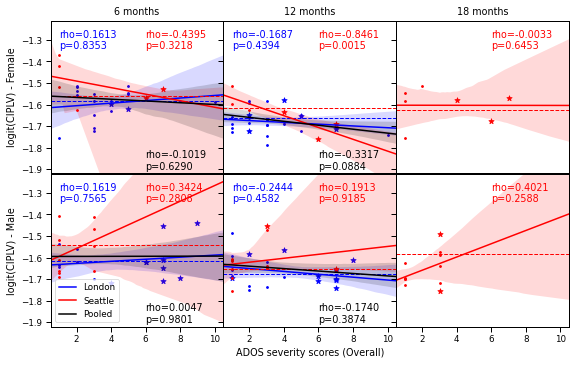

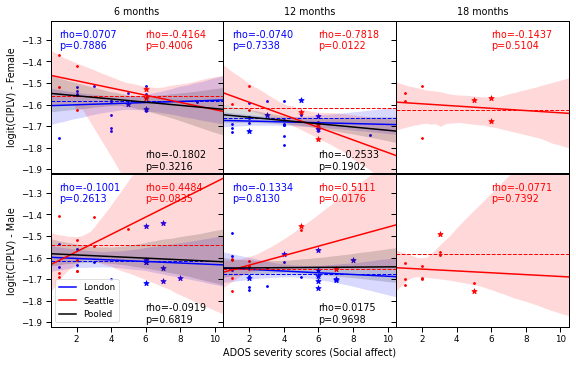

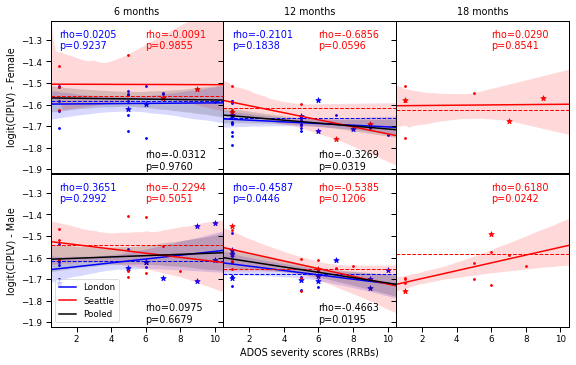

In [43]:
plot_ados_reg(suffix="_earliest")


======================== adoscss_latest =========================
Intercept                  6.512757e-73
sex[T.M]                   2.664603e-01
site[T.Seattle]            6.777375e-01
adoscss_latest             1.855920e-01
adoscss_latest:sex[T.M]    3.459470e-01
age                        9.766117e-05
site[T.Seattle]:age        2.604599e-01
dtype: float64 Intercept                 -1.470114
sex[T.M]                  -0.030023
site[T.Seattle]            0.019542
adoscss_latest            -0.006009
adoscss_latest:sex[T.M]    0.005686
age                       -0.013287
site[T.Seattle]:age        0.004659
dtype: float64


/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_65002/2759810661.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["log_con"] = logit(tmp.con)


London 6 F 18
Seattle 6 F 6
London 12 F 27
Seattle 12 F 6
Seattle 18 F 7
London 6 M 15
Seattle 6 M 10
London 12 M 19
Seattle 12 M 11
Seattle 18 M 11

======================== ados_sacss_latest =========================
Intercept                     1.576476e-69
sex[T.M]                      1.320573e-01
site[T.Seattle]               7.064792e-01
ados_sacss_latest             1.360277e-01
ados_sacss_latest:sex[T.M]    1.808367e-01
age                           7.017358e-05
site[T.Seattle]:age           2.391095e-01
dtype: float64 Intercept                    -1.459919
sex[T.M]                     -0.045765
site[T.Seattle]               0.017604
ados_sacss_latest            -0.006469
ados_sacss_latest:sex[T.M]    0.007900
age                          -0.013501
site[T.Seattle]:age           0.004854
dtype: float64


/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_65002/2759810661.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["log_con"] = logit(tmp.con)


London 6 F 18
Seattle 6 F 6
London 12 F 27
Seattle 12 F 6
Seattle 18 F 7
London 6 M 15
Seattle 6 M 10
London 12 M 19
Seattle 12 M 11
Seattle 18 M 11

======================== ados_rrbcss_latest =========================
Intercept                      1.895586e-75
sex[T.M]                       8.496633e-01
site[T.Seattle]                7.900320e-01
ados_rrbcss_latest             5.189197e-01
ados_rrbcss_latest:sex[T.M]    7.026470e-01
age                            1.124411e-04
site[T.Seattle]:age            2.556728e-01
dtype: float64 Intercept                     -1.478357
sex[T.M]                       0.006031
site[T.Seattle]                0.012852
ados_rrbcss_latest            -0.002760
ados_rrbcss_latest:sex[T.M]   -0.002381
age                           -0.013396
site[T.Seattle]:age            0.004775
dtype: float64


/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_65002/2759810661.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["log_con"] = logit(tmp.con)


London 6 F 18
Seattle 6 F 6
London 12 F 27
Seattle 12 F 6
Seattle 18 F 7
London 6 M 15
Seattle 6 M 10
London 12 M 19
Seattle 12 M 11
Seattle 18 M 11


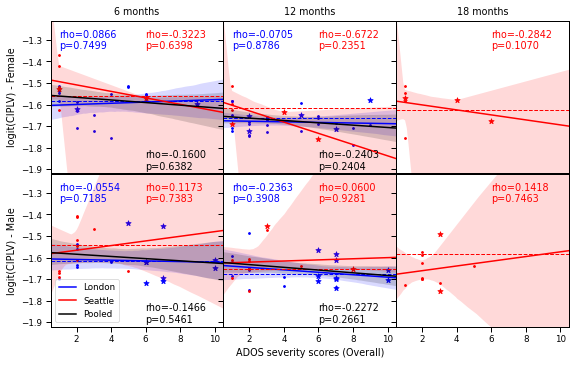

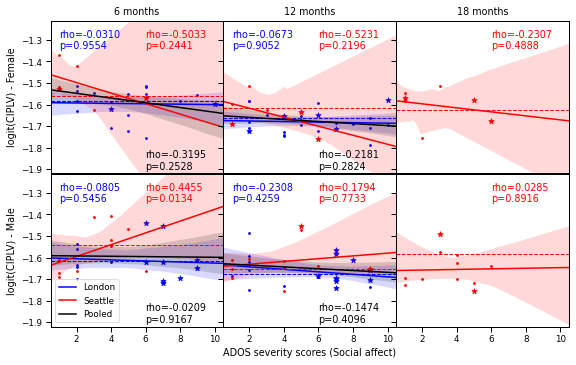

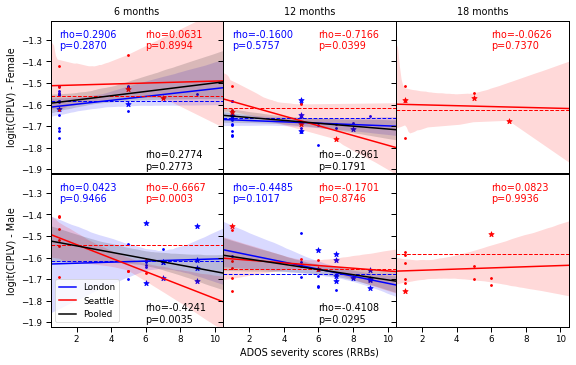

In [44]:
plot_ados_reg(suffix="_latest")

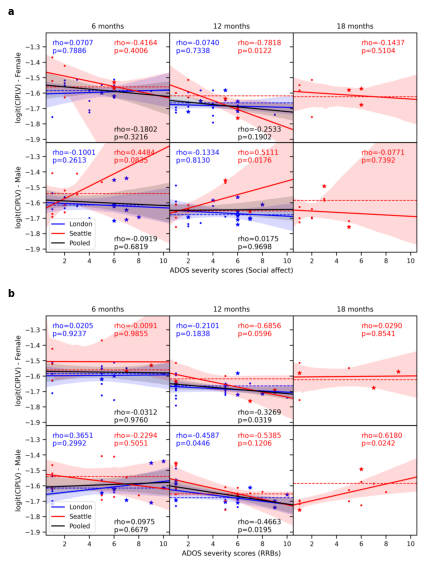

In [45]:
img_file_names = ["sex_ados_sacss_earliest_regressions.png", "sex_ados_rrbcss_earliest_regressions.png"]

fig, axes = plt.subplots(2, 1, figsize=(6, 8))
for ax, file_name in zip(axes, img_file_names):
    img = plt.imread("images/" + file_name)
    ax.imshow(img)
    ax.axis(False)

fig.text(0.02, 0.98, "a", fontweight="bold")    
fig.text(0.02, 0.49, "b", fontweight="bold")        
    
fig.tight_layout()
fig.savefig("images/" + "sex_ados_sacss_rbbcss_earliest_regressions.png", dpi=300)


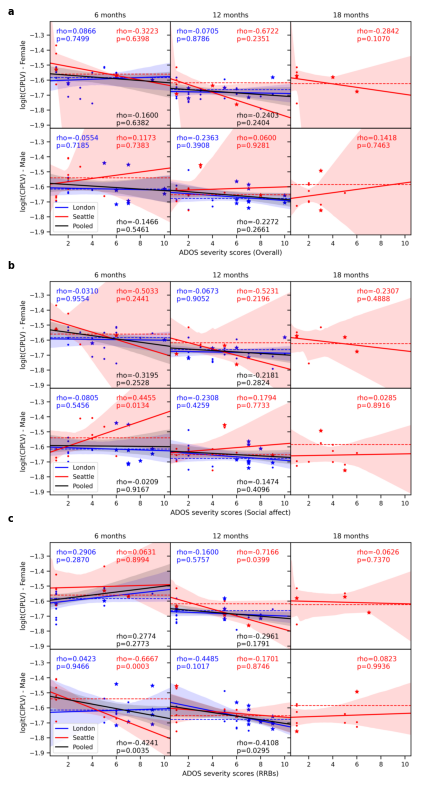

In [46]:
img_file_names = ["sex_adoscss_latest_regressions.png", "sex_ados_sacss_latest_regressions.png", "sex_ados_rrbcss_latest_regressions.png"]

fig, axes = plt.subplots(3, 1, figsize=(6, 11))
for ax, file_name in zip(axes, img_file_names):
    img = plt.imread("images/" + file_name)
    ax.imshow(img)
    ax.axis(False)

fig.text(0.02, 0.98, "a", fontweight="bold")    
fig.text(0.02, 0.66, "b", fontweight="bold")        
fig.text(0.02, 0.34, "c", fontweight="bold")        
    
fig.tight_layout()
fig.savefig("images/" + "sex_ados_all_latest_regressions.png", dpi=300)

### Sample size comparison with literature

In [52]:
eeg_asd = [9, 10, 12, 87, 19, 15, 20, 430, 430, 72, 6, 16, 12, 12, 27, 14, 9, 21, 15, 27, 18, 10, 30, 5, 21, 34, 10]
eeg_control = [9, 10, 19, 29, 13, 15, 20, 554, 554, 31, 8, 17, 12, 19, 20, 19, 13, 16, 55, 18, 44, 46, 49, 21, 14]
eeg_total = [18, 74, 20, 31, 137, 32, 30, 40, 984, 984, 103, 14, 33, 24, 32, 47, 33, 22, 21, 31, 82, 36, 54, 105, 54, 42, 34, 24]

meg_asd = [14, 12, 16, 9, 26, 11, 17, 15, 35, 26, 50, 15, 10, 22, 20, 8, 8, 17, 16]
meg_control = [14, 35, 14, 10, 22, 11, 20, 20, 35, 26, 50, 15, 8, 17, 20, 8, 8, 20, 15]
meg_total = [28, 63, 30, 19, 48, 22, 37, 35, 70, 52, 100, 30, 18, 39, 40, 16, 16, 37, 31]


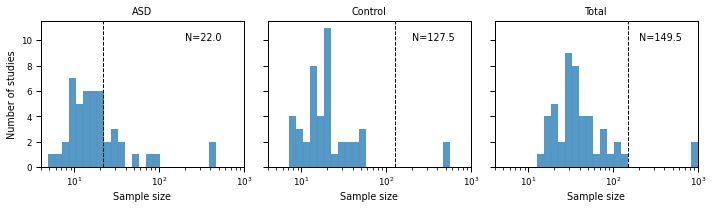

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)

bins = 10**np.linspace(np.log10(4), np.log10(1000), 30)
sns.histplot(eeg_asd + meg_asd, label="asd", ax=axes[0], bins=bins)
sns.histplot(eeg_control + meg_control, label="control", ax=axes[1], bins=bins)
sns.histplot(eeg_total + meg_total, label="total", ax=axes[2], bins=bins)

axes[0].set_title("ASD")
axes[1].set_title("Control")
axes[2].set_title("Total")
axes[0].set_ylabel("Number of studies")
for ax in axes:
    ax.set_xscale('log')
    ax.set_xlim(4, 1000)
    ax.set_xlabel("Sample size")
    
# Total combined, average across time points, HRA- as control    
tmp = dat.groupby(["group", "site", "age", "subject"]).mean()\
         .groupby(["group", "site", "age"], observed=True).count()[["con"]].reset_index()
tmp = tmp[tmp.age != 18]
total_asd = tmp[tmp.group == "HRA-ASD"].groupby("site").mean()["con"].sum()
total_control = tmp[tmp.group != "HRA-ASD"].groupby(["group", "site"]).mean()["con"].sum()


axes[0].axvline(x=total_asd, color="k", linestyle="dashed")
axes[1].axvline(x=total_control, color="k", linestyle="dashed")
axes[2].axvline(x=total_asd + total_control, color="k", linestyle="dashed")
 
axes[0].text(200, 10, "N={}".format(total_asd), color="k")
axes[1].text(200, 10, "N={}".format(total_control), color="k")
axes[2].text(200, 10, "N={}".format(total_asd + total_control), color="k")

fig.tight_layout()

fig.savefig("images/" + "sample_size_hist.png", dpi=300)

In [55]:
x = np.array(eeg_asd + meg_asd)
print(np.sum(x <= 10)/len(x), np.sum(x <= 25)/len(x))

0.2391304347826087 0.7391304347826086
